In [1]:
import pandas as pd
import csv
import jieba
import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#加载文本
df1 = pd.read_csv('长沙市_内容_2.csv', encoding='gb18030', sep=',', header=None)
df = df1.append(df1) 
#加载停用词
sw = pd.read_csv('停用词.txt',encoding='utf-8', sep='\n', quoting=csv.QUOTE_NONE, header=None)


In [3]:
#将文档分词并去除停用词
stop_list = sw[0].tolist() 
df_cut = df1[0].apply(lambda x : [i for i in jieba.lcut(x) if i not in stop_list])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


In [4]:
for line in df_cut:#去除无关字符串
    while True:
        if '\n' in line:
            line.remove('\n')
        elif '\t' in line:
            line.remove('\t')
        elif ' ' in line:
            line.remove(' ')
        elif '\r' in line:            
            line.remove('\r')        
        elif '\r\n' in line:            
            line.remove('\r\n') 
        elif '\xa0' in line:            
            line.remove('\xa0') 
        else:
            break

In [5]:
words=[]
for content in df_cut:
    words.extend(content)

#创建分词数据框
corpus = pd.DataFrame(words, columns=['word'])
corpus['cnt'] = 1

#分组统计
g = corpus.groupby(['word']).agg({'cnt': 'count'}).sort_values('cnt', ascending=False)

g.head(20)

,cnt
word,
小区,28077
业主,23208
建设,22322
公司,22019
中,21230
办理,19987
居民,18327
管理,17329
解决,16961


In [6]:
g.to_csv('C:\\Users\\Administrator\\Desktop\\主题分析文件\\词频.csv',mode='w',encoding='utf-8',sep=',')

In [7]:
df_cut.to_csv('C:\\Users\\Administrator\\Desktop\\主题分析文件\\分词.csv',mode='w',encoding='utf-8',sep=',',header=False)

In [8]:
dictionary = corpora.Dictionary(df_cut)#制作词袋
V = len(dictionary)

#将分词列表转换为索引，并计数
corpus = [dictionary.doc2bow(text) for text in df_cut]

#计算tf-idf值
corpus_tfidf = models.TfidfModel(corpus)[corpus]

In [9]:
model_list = []
p_list = []
c_list = []

for topic_num in range(10,30):
    print('完成一个')
    lda = LdaModel(corpus_tfidf, num_topics=topic_num, id2word=dictionary)
                   #alpha=0.01, eta=0.01, minimum_probability=0.001,update_every=1, chunksize=100, passes=1)
    model_list.append(topic_num)
    
    #计算困惑度
    p_values = lda.log_perplexity(corpus_tfidf)
    p_list.append(p_values)
    #print('%d 个主题的Perplexity为: ' % topic_num, p_values)
    
    #计算一致性
    cmodel = CoherenceModel(model=lda,texts=df_cut,dictionary=dictionary,coherence='c_v')
    c_list.append(round(cmodel.get_coherence(),3))
    #print('%d 个主题的Coherence为: ' % (topic_num), round(cmodel.get_coherence(),3))

完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个
完成一个


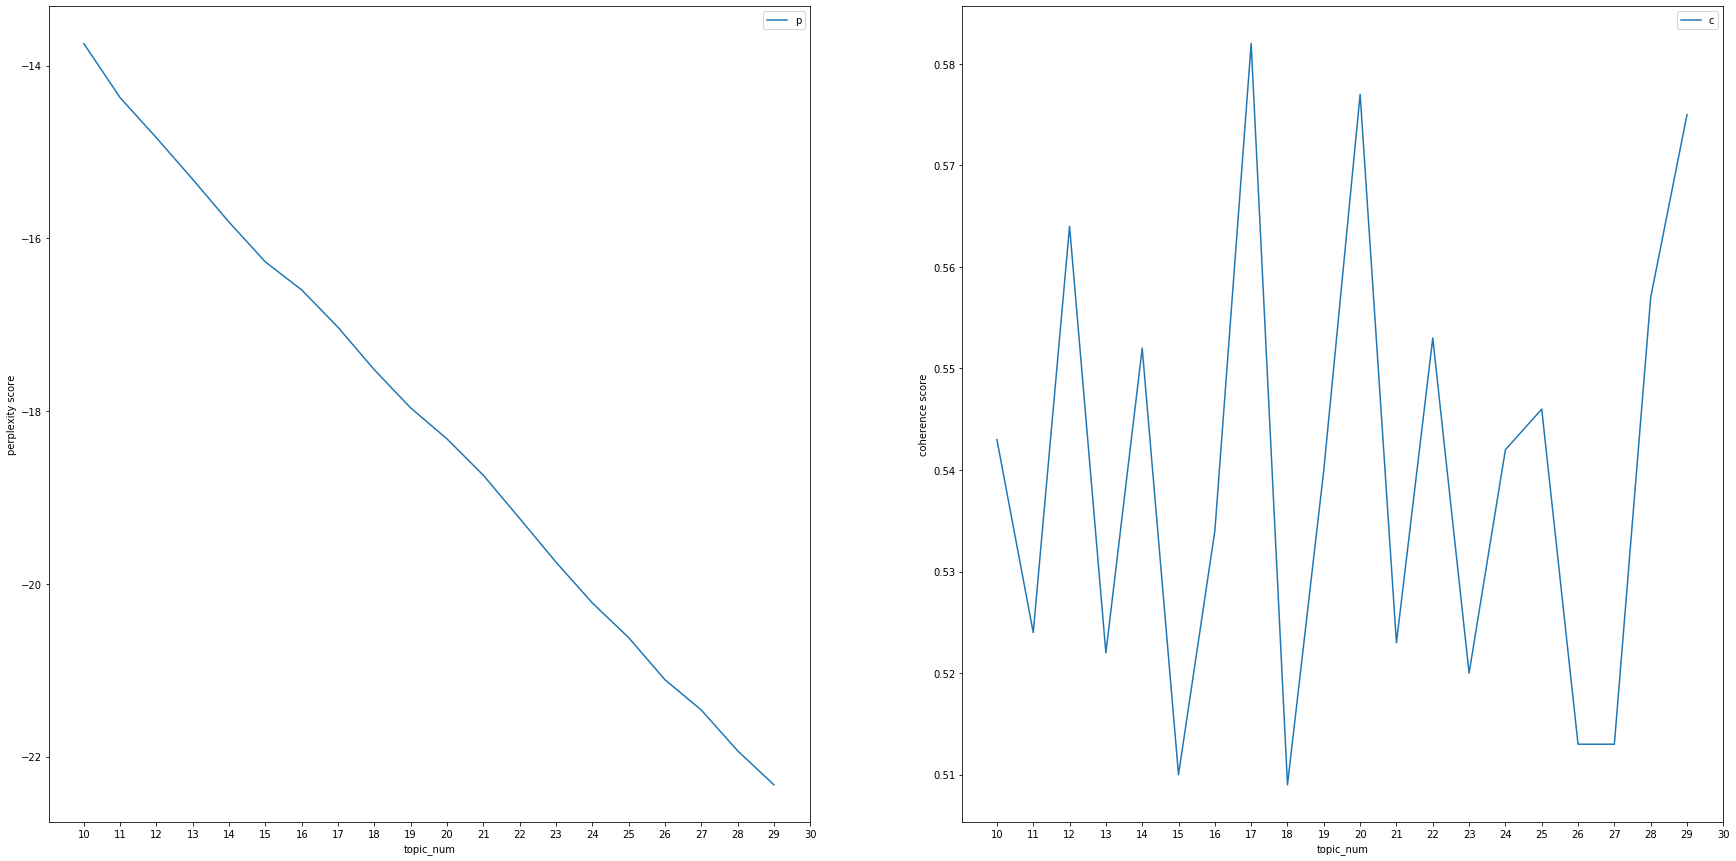

In [10]:
#困惑度和一致性折线图
plt.figure(figsize=(30,15))    
plt.subplot(1,2,1)
plt.plot(model_list,p_list)
plt.xticks(np.linspace(10, 30, 21))
plt.xlabel('topic_num')
plt.ylabel('perplexity score')
plt.legend(('perplexity_values'), loc='best')

plt.subplot(1,2,2)
plt.plot(model_list,c_list)
plt.xticks(np.linspace(10, 30, 21))
plt.xlabel('topic_num')
plt.ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')

plt.show()

In [15]:
topic_num = 29 #主题数（根据折线图确定）
lda = models.LdaModel(corpus_tfidf,num_topics=topic_num,id2word=dictionary) #LDA模型训练
for i in range(topic_num):
    print('主题%d:' % (i+1))
    print(lda.show_topic(i))#输出每个主题

主题1:
[('网吧', 0.008462436), ('衡阳', 0.0022568635), ('游客', 0.0018656903), ('烈士', 0.0010443256), ('电池', 0.0009578642), ('新姚', 0.0009155036), ('丽都', 0.0008976955), ('有线', 0.00084956066), ('上网', 0.0007214758), ('未成年人', 0.00053919543)]
主题2:
[('劳动', 0.006659014), ('劳动者', 0.0063988464), ('监察部门', 0.0057158195), ('用人单位', 0.0054713525), ('仲裁', 0.0051063937), ('劳动合同', 0.0033289094), ('工资', 0.0030614107), ('发工资', 0.0027970234), ('拖欠工资', 0.0022812255), ('劳动法', 0.0017964332)]
主题3:
[('赌博', 0.007297161), ('准迁证', 0.0014898169), ('药房', 0.0009182805), ('载客', 0.00088334683), ('基本农田', 0.0006906293), ('颐美会', 0.00039822722), ('907A', 0.00033961583), ('水泵房', 0.00032307798), ('低频', 0.0003088425), ('限值', 0.00028480432)]
主题4:
[('农业户口', 0.007364587), ('犯罪', 0.005329743), ('非农业', 0.004313356), ('转农', 0.004170034), ('110', 0.0037911327), ('摩托', 0.003623869), ('公安部', 0.0034566466), ('钱包', 0.0025116766), ('原籍', 0.0024531288), ('驾驶证', 0.0024025564)]
主题5:
[('工伤', 0.0065207407), ('牌楼', 0.0022410017), ('工伤保险', 0.0017894104

In [12]:
#import pyLDAvis
#import pyLDAvis.gensim
#vis_data = pyLDAvis.gensim.prepare(lda,corpus,dictionary)
#pyLDAvis.show(vis_data)